# Information 
100 stop sign pictures

100 not stop sign pictures


# Imports

In [116]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
import torch.nn as nn
import time
import datetime


# Useful Functions

For plotting cost and accuracy

In [117]:
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    

Plotting the image

In [118]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

Comparing the prediction and the actual value

In [119]:
def result(model,x,y):
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

Nvidia CUDA

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


# Loading the Data

We will
- change the shape of the image
- convert to tensor
- normalize the image
- perform data augmentation

In [121]:
stop_file_path = "data/stop"
not_stop_file_path = "data/not_stop"

In [122]:
stop_files = []
for file in os.listdir(stop_file_path):
    if file.endswith(".jpg") or file.endswith(".JPG") or file.endswith(".jpeg"):
        stop_files.append(os.path.join(stop_file_path,file))

not_stop_files = []
for file in os.listdir(not_stop_file_path):
    if file.endswith(".jpg") or file.endswith(".JPG") or file.endswith(".jpeg"):
        not_stop_files.append(os.path.join(not_stop_file_path,file))

In [123]:
all_files = []

index = 0
for file in stop_files:
    all_files.insert(index, file)
    index += 2

index = 1
for file in not_stop_files:
    all_files.insert(index, file)
    index += 2

%80 percent of the data will be used for training and rest will be used for testing

In [124]:
len(all_files)

190

In [125]:
train_files = all_files[0:152]
validation_files = all_files[152:]

We can plot our images

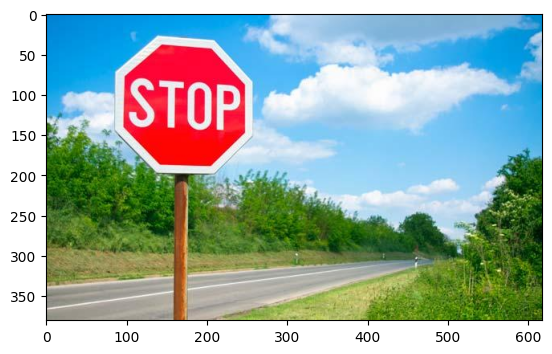

In [126]:
image = Image.open(train_files[66])
plt.imshow(image)

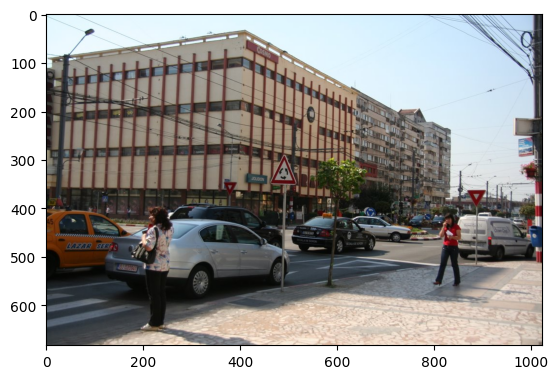

In [127]:
image = Image.open(validation_files[13])
plt.imshow(image)

# Datasets

In [128]:
class Dataset(Dataset):

    def __init__(self,transform,train=True):
        
        self.transform = transform
        self.files = []
        if train:
            self.files = train_files
            self.len=len(self.files)
        else:
            self.files = validation_files
            self.len=len(self.files)
  
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        image=Image.open(self.files[idx])
        
        if self.transform:
            image = self.transform(image)
        
        if idx%2==0:
            target = 0
        else:
            target = 1

        return image, target

In [129]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

composed = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
    ])

In [130]:
train_dataset = Dataset(transform= composed, train= True)
validation_dataset = Dataset(transform= composed, train= False)

# Hyperparameters

In [131]:
n_epochs=10
batch_size=32
lr=0.000001
momentum=0.9

# Model

In [132]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs):
    loss_list = []
    accuracy_list = []
    correct = 0
    n_test = len(validation_dataset)
    accuracy_best = 0
    
    for epoch in range(n_epochs):
        loss_sublist = []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            model.train()

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step() 

            optimizer.zero_grad()
    
        loss_list.append(np.mean(loss_sublist))

        correct = 0
        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, predicted = torch.max(z.data, 1)
            correct += (predicted == y_test).sum().item()
            accuracy = correct / n_test
            accuracy_list.append(accuracy)
            if accuracy > accuracy_best:
                accuracy_best = accuracy
                torch.save(model.state_dict(), "model.pt")

        print("epoch {}/{} done".format(epoch, n_epochs))

    return accuracy_list,loss_list, model

In [133]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
       param.requires_grad = False

model.fc = nn.Linear(512, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=validation_dataset , batch_size=1)

# Training the model

In [134]:
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time: ", elapsed_time )

epoch 0/10 done
epoch 1/10 done
epoch 2/10 done
epoch 3/10 done
epoch 4/10 done
epoch 5/10 done
epoch 6/10 done
epoch 7/10 done
epoch 8/10 done
epoch 9/10 done
Elapsed time:  125.23749709129333


In [135]:
torch.save(model.state_dict(), "model.pt")

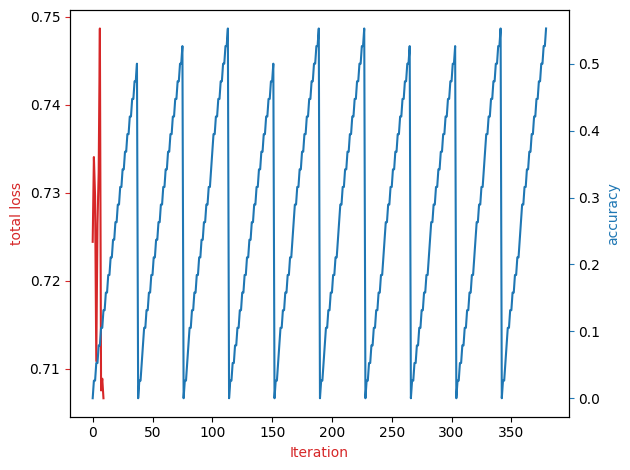

In [156]:
plot_stuff(loss_list,accuracy_list)

In [159]:
accuracy_list[::-1][0]

0.5526315789473685

Low accuracy :(

# Using the model

In [137]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Using the model with images from test_set

(224, 224, 3)


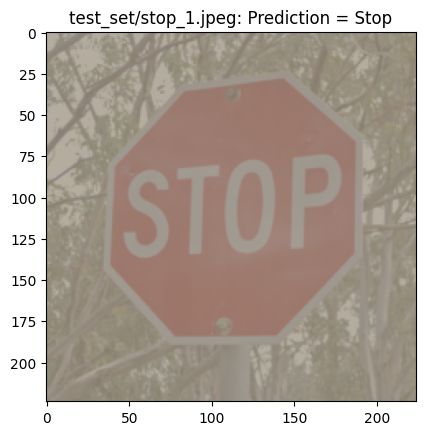

(224, 224, 3)


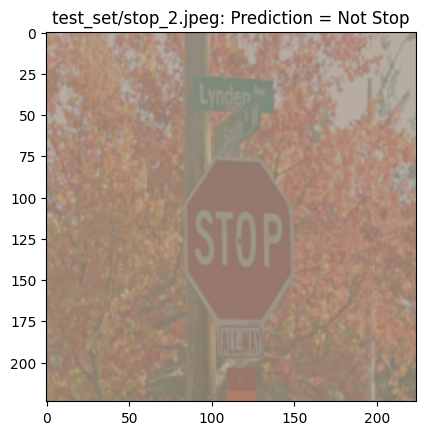

(224, 224, 3)


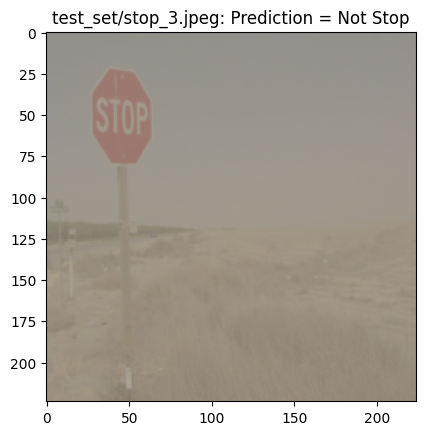

(224, 224, 3)


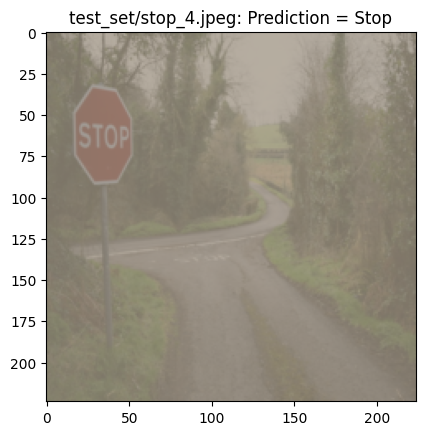

(224, 224, 3)


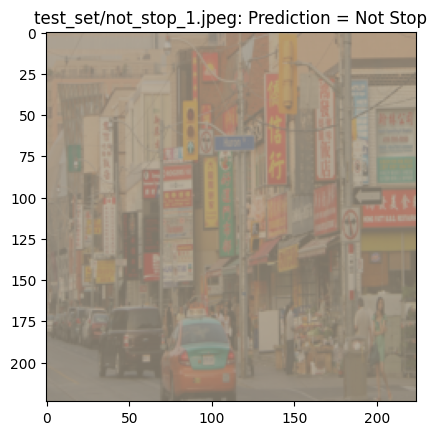

(224, 224, 3)


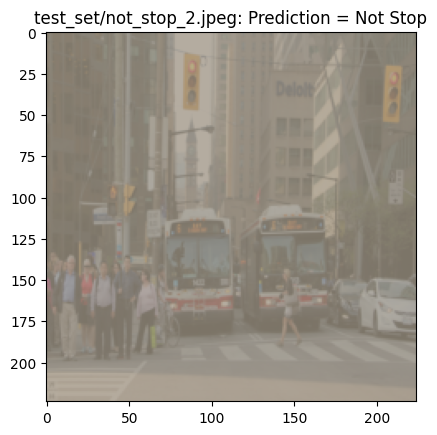

(224, 224, 3)


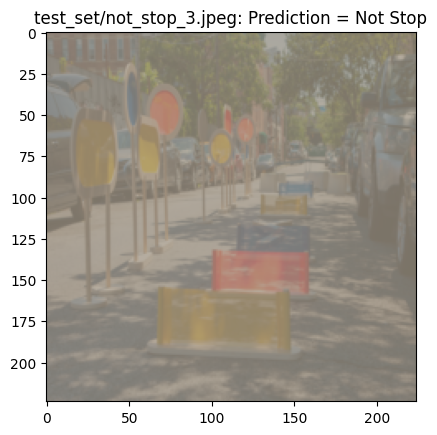

(224, 224, 3)


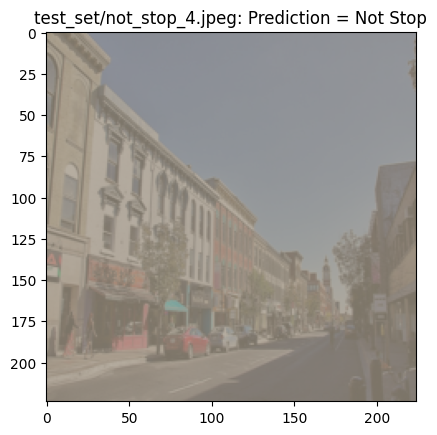

In [142]:
images = ['test_set/stop_1.jpeg','test_set/stop_2.jpeg', 
          "test_set/stop_3.jpeg", "test_set/stop_4.jpeg",
          'test_set/not_stop_1.jpeg', "test_set/not_stop_2.jpeg",
          "test_set/not_stop_3.jpeg", "test_set/not_stop_4.jpeg"]
for image_name in images:
    image = Image.open(image_name)
    transform = composed = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    x = transform(image)
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat == 1:
        prediction ="Not Stop"
    else:
        prediction = "Stop"
    
    imshow_(transform(image),image_name+": Prediction = "+prediction)